# Predicting The Re-Sale Value of Used Cars

## Problem Statement

In the United States used cars represent almost half of the U.S. auto retail market and is the largest retail segment of the economy. There has been a shift by consumers to purchase more affordable previously owned vechinces as automobile debt has surpassed 1 trillion dollars and now makes up 9.5% of American consumer debt. The market for used vehicles is challenging to navigate for many consumers as prices can vary widely as many formulas fail to take into the many nuances of a car.

Consumers can use online valuation calculators to get an estimate on a car but these sites tend to only factor in a few features like make, model and miles driven. They also value the car on a straight line depreciation formula which can be overly simplistic, especially for cars that were well maintained by the previous owner. Buyers may look to third party appraisals to price a second hand car, but often these appraisals are costly and time consuming. 

In the current used car market landscape there is a need by both buyers and sellers for a price prediciton method to better determine the fair market value of a car. Individual sellers can use this price prediciton model to better price their cars before putting them on the market. Buyers can use additional predictions to reference them against popular online valuators to get a better idea of the fair market value of a car. In the often times overwhelming used car market a price predicition model that accounts for the nuances of an automobiles many features will benefit both buyers and sellers to help determine the actual worth of a used car. 

A series of regression models will be utilized to predict the price of the cars in our dataset. These include; Linear Regression, Ridge, Lasso, Decision Trees, Random Forest, Extra Trees and Gradient Boost. The model will be evaluated using the metric Root Mean Squared Error (RMSE). This metric was chosen because it provides us with a number that is more easily interpreted for our parameter of interst, whic is price. In this case the metric will show the difference in monetary units (Euros) the predicted price was from the actual price. A benchmark RMSE score within 10% of the mean value of the cars in our dataset is how we will determine if we have a successful model. This would mean if the cars in the data set had a mean value of 5,000 a succesful RMSE score would be <= 500. A score like this would be helpful as a secondary appraisal to help consumers confirm they are paying a fair value for a used car. 

In [1869]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

## Executive Summary

Predicting the price of used cars is an important problem that has great value in real world applications. As more consumers shift away from leasing or financing cars, more people are looking toward the used car market. Navigating the used car market can be challenging and it is unclear to many buyers and sellers as what the fair market value of a car is.  Intuition tells us that the older the car and the more miles it has on the odometer the cheaper it will be. However, in the data that was collected for this project we observed prices varying greatly in both the age and miles driven categories. This led us to believe that there are many additional features that are affecting the price of a used car. 

Given the extreme range in our target variable price we knew we would have to remove outliers on both ends of the price range. There were cars listed at over €150,000 and cars listed under €500. For a used car prediction model we didn’t want to have cars priced extremely high as these vehicles are likely exotics or collectors items and did not represent what we believed to be the average used car. Addtionally we wanted to remove cars below 500 euros as these could be considered “junkers” and may be bought just for parts or scrap metal. During the modelling phase we kept scaling back on the max price as the scores of the model were very poor. The high price cars were making it very difficult for the model to learn. When going back to look at the distribution of prices the majority of the cars were in the €500 – €20,000 euro. We ended up settling on this price range for our target variable. We believed this was a true representation on what a normal person would spend on a used car. Prices above this threshold were equivalent of the price of some new cars and we wanted to focus on a realistic price range for the average consumer. 

We wanted to use a number of different models in attempt to get the best score. We started with a simplified approach dropping the null values from our data set and running a linear regression model. We then went back and imputed the mode values for our categorical variables with missing values and re-ran the linear regression model where we observed an improvement in our score. We began to observe training scores that were much better than testing scores on many of the models. We removed the feature "car models" becuase we believed this was making it challenging for the models to train because of how many car model types were in the dataset. This was likely creating too much noise and was causing the models to overfit. When introducing tree based models we observed better scores and our Random Forest Model was our best performing model. 

Overall, the scores our models produced were poor. There were only a few features that had any impactful correlation on our models. Besides age and kilometers driven there was very weak correlation among the other features included in the model. The additional features created too much noise and it made it challenging for the models to learn.  When we scaled back to just a few features the noise was reduced and the models were less overfit but they still performed poorly. Due to the wide range in price amongst every feature, especially model and brand of car it made it extremely difficult for the models to make accurate price predictions. These results reinforce the idea that setting the actual price of a used automobile is extremely challenging and is most likely why straight line depreciation is used for this problem. 

### Contents:
- [Import Data](#Import-Data)
- [Data Dictionary](#Data-Dictionary)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Convert Date Columns to Datetime](#Convert-Date-Columns-to-Datetime)
    - [Identify Missing Values](#Identify-Missing-Values)
    - [Address Outliers In Data Set](#Address-Outliers-In-Data-Set)
    - [Price](#Price)
    - [Kilometers Driven](#Kilometers-Driven)
    - [Power PS](#Power-PS)
    - [Vehichle Type](#Vehichle-Type)
    - [Car Brands](#Car-Brands)
    - [Fuel Types](#Fuel-Types)
    - [Transmission Type](#Transmission-Type)
    - [Damage To Vehicle](#Damage-To-Vehicle)
    - [Revisting Max Price](#Revisting-Max-Price)
- [Preprocessing](#Preprocessing)
- [Train Test Split](#Train-Test-Split)
- [Modeling](#Modeling)
   - [Baseline Model](#Baseline-Model)
   - [Linear Regression](#Linear-Regression)
   - [Ridge](#Ridge)
   - [Lasso](#Lasso)
   - [Decision Tree](#Decision-Tree)
   - [Random Forest](#Random-Forest)
   - [Extra Trees](#Extra-Trees)
   - [Gradient Boost](#Gradient-Boost)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Residuals Plot](#Residuals-Plot)
    - [Residuals Distribution](#Residuals-Distribution)
    - [Interpretable Model/Model Coefficients](#Interpretable-Model/Model-Coefficients)
    - [Modeling Assumptions](#Modeling-Assumptions)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)
- [Sources](#Sources)



## Import Data

In [1758]:
df = pd.read_csv('./data/autos.csv', encoding = 'latin-1')

## Data Dictionary

The data for this project was taken from autos from Kaggle. The data was scraped from Ebay Kleinanzeigen, which is a Ebay subsidiary based in Germany. Translation of German words will be provided at points along this notebook. 

|Column|Type|Description|
|:---|---|:---|
|Date Crawled|string|When this ad was first scraped from the website 
|Name|string|Name of the Car (Ex. VW Golf 1.87)
|Seller|string|Seller Type, Private or Dealer 
|Offer Type|string|The average sat Math score
|Price|int|Listed price of car
|AB Test|string|Offer is a test or control 
|Vehicle Type|string|Type of vehcile (SUV, Coupe, Van, etc.)
|Year of Registration|int|When the vehicle was first registered
|Gearbox|string|Transmission type (Manual or Automatic)
|Power Ps|int|Power of the car is PS
|Model|string|Model of the vehicle (VW Golf, Audi A4, BMW M3)
|Kilometer|int|Number of ilometers driven
|Month of Registraion|string|Which month the car was first registered
|Fuel Type|string|What type of fuel the car uses (Diesel, Gasoline, Electric)
|Brand|string|The Vehicle Manufactuer (Toyota, Volkwagen, Honda)
|Not Repaired Damage|string|If the car has damage that is unrepaired
|Date Created|string|The date for which the ad at ebay was created
|Postal Code|int|Postal Code of Seller/Cars location
|Last Seen|string|When the web scraper last saw the ad online

In [1759]:
new_columns_dict = {
    'dateCrawled': 'date crawled',
    'offerType': 'offer type',
    'abtest': 'AB test',
    'vehicleType': 'vehicle type',
    'yearOfRegistration': 'year of registration',
    'gearbox': 'gear box',
    'powerPS': 'power ps',
    'monthOfRegistration': 'month of registration',
    'fuelType': 'fuel type',
    'notRepairedDamage': 'unrepaired damage',
    'dateCreated': 'date created',
    'nrOfPictures': 'pictures of car',
    'postalCode':'postal code',
    'lastSeen': 'last seen',

}

df.rename(columns=new_columns_dict, inplace=True)

Column headers were renamed to be more descriptive and human readable. 

# Exploratory Data Analysis

In [1760]:
df.shape

(371528, 20)

Our data is comprised of 371,528 rows, which are the individual used car listings that were scraped from ebay-klienzwagan (E-Bay subsidiary based in Germany). There are 20 columsn which represent various features of the used car being sold. 

In [1761]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,371528.0,17295.141865,3.587954e+06,0.0,1150.0,2950.0,7200.0,2.147484e+09
year of registration,371528.0,2004.577997,9.286660e+01,1000.0,1999.0,2003.0,2008.0,9.999000e+03
power ps,371528.0,115.549477,1.921396e+02,0.0,70.0,105.0,150.0,2.000000e+04
kilometer,371528.0,125618.688228,4.011234e+04,5000.0,125000.0,150000.0,150000.0,1.500000e+05
month of registration,371528.0,5.734445,3.712412e+00,0.0,3.0,6.0,9.0,1.200000e+01
pictures of car,371528.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
postal code,371528.0,50820.667640,2.579908e+04,1067.0,30459.0,49610.0,71546.0,9.999800e+04


The above chart gives us an intial look at some of the summmary statisitcs of our data. We can see that the mean price of a used car in the dataset is €17,295. This price seems high for a used car which makes one think there may be a large number of outliers in the dataset. We also observe a mean value of 125,618 for kilometer which represents the distance the car has been driven. We can infer from this number that many of the cars in the dataset have higher mileage. 

In [1762]:
df.dtypes

date crawled             object
name                     object
seller                   object
offer type               object
price                     int64
AB test                  object
vehicle type             object
year of registration      int64
gear box                 object
power ps                  int64
model                    object
kilometer                 int64
month of registration     int64
fuel type                object
brand                    object
unrepaired damage        object
date created             object
pictures of car           int64
postal code               int64
last seen                object
dtype: object

The above shows what type of data types the features in the dataset are. We may need to convert data types in order to analyze and process the data appropriately. For example date crawled, date created and last seen are currently objects. We will need to convert this features to date times in order to calculate how long a listing has been posted on the website. We would be unable to do this if these features remained as objects. 

From the features listed above we will have to determine during the exploratory data analysis process to see what features will be included and which should be removed. We will only want to introduce features we believe have a linear relationship with price into our model. If the feature is unrelated it provides no benefit and can negatively affect the performance of the model. 

### Convert date columns to datetime

In [1763]:
df['date crawled'] = pd.to_datetime(df['date crawled'])

Converting the feature 'date crawled', which is when the listing for the used car was scraped from the website from an object to datetime. 

In [1764]:
df['date created'] = pd.to_datetime(df['date created'])

Converting the feature 'date created', which is when the listing for the used car was intially put up on the website from an object to datetime in preparation to determine how long the listing was posted. 

In [1765]:
df['last seen'] = pd.to_datetime(df['last seen'])

Converting the feature 'last seen', which is when the listing for the used car was last seen on the website from an object to datetime in preparation to determine how long the listing was posted. 

In [1766]:
df['ad duration'] = df['last seen'] - df['date created']

In order to create the feature "ad duration" we converted the features realted to date/time to datetime. We then subtracted "date created" from "last seen" to calculate the number of days the listing has been up. Ad duration is then converted to an integer which will be a continuous variable that is included in our model.

In [1769]:
ad_test = df['ad duration'][0]
ad_test.days

14

Testing to see the differnce has been converted to number of days between date created and last seen. 

In [1770]:
df['ad duration'] = df['ad duration'].apply(lambda x: x.days)

Above we convert all ad duration values to days in the data set. We believe the features last seen and date created could be used to estimate how long a car has been listed online. A listing that has been up on the website for a longer period of time may indicate that the car is undesirable and may be a feature that is related to the price. 

In order to create the feature "ad duration" we converted the features realted to date/time to datetime. We then subtracted "date created" from "last seen" to calculate the number of days the listing has been up. Ad duration is then converted to an integer which will be a continuous variable that is included in our model.

### Identify Missing Values

We want to identify any missing values we have in our dataset so we can decide how to address the missing data prior to modeling. That data that has been collected is valuable and we do not want to drop a row from our dataset if it is missing a value from one feature. 

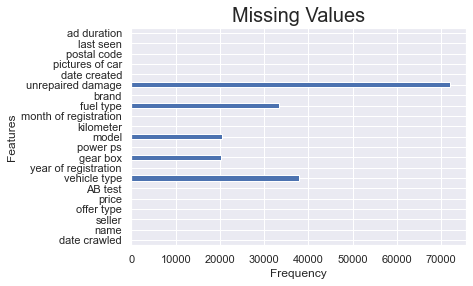

In [1771]:
#visualize null values
plt.title("Missing Values", size = 20)
plt.xlabel("Frequency")
plt.ylabel("Features")
df.isnull().sum().plot(kind = 'barh');

The above graph shows which features are missing from our dataset. Five features have missing values with "unrepaired damage" having the highest count of missing values. Since this category only applies to owners who have had damage to their car it is possible that owners who did not have damage to their car omitted a response to this question while listing their car for sale. 

The other missing categories vehicle type, model, gear box, and vehicle type are important features of a car that all cars have. It is unclear why these features are missing but we will have to address these missing values in some way. If we are missing the vehicle type but have the model of the car we will be able to determine the vehicle type with outside research. 

We also want to determine if any null values are less than 5% of the dataset. If so we may just drop the null values from the dataset, if not we will have to impute the missing data or take a pattern submodel approach if possible. 

In [1772]:
nulls = df.isnull().sum()
nulls = pd.DataFrame(nulls, columns = ['null'])
total = len(df)
nulls['percent']  = nulls['null']/total
nulls.sort_values('percent', ascending = False)

,null,percent
unrepaired damage,72060,0.193956
vehicle type,37869,0.101928
fuel type,33386,0.089861
model,20484,0.055134
gear box,20209,0.054394
month of registration,0,0.000000
last seen,0,0.000000
postal code,0,0.000000
pictures of car,0,0.000000
date created,0,0.000000


Above shows us the percentage of missing values in our dataset. If we are missing 5% or less from one feature it may be ok to drop these car listings as this amount is inconsequential. Model and gear box are both just above the 5% threshold and we will not drop these data points and will have to determine another way to address the missing values. 

#### Missing Data

We want to know if the data is Missing Completely At Random (MCAR), Missing At Random (MAR) or Not Missing At Random (NMAR). We will look to see if any of the columns have a higher number of shared nulls to see if a pattern submodel approach can be taken to handle the missing data. Pattern submodels are a set of submodels for every missing data pattern that are fit using only data from that pattern. This will also allow us to not impute any missing values, which is essentially making up data and can be an ureliable technique when handling missing data. 

In [1773]:
no_damage = df['unrepaired damage'].isnull()
vtype = df["vehicle type"].isnull()
shared_null = no_damage & vtype

In [1774]:
print(f"No Damage Nulls: {sum(no_damage)}")
print(f"Vehicle Type Nulls: {sum(vtype)}")
print(f"Shared Nulls: {sum(shared_null)}")

No Damage Nulls: 72060
Vehicle Type Nulls: 37869
Shared Nulls: 20756


The first two features we compared for missing data values was unrepaired damage and vehicle type. The two features only shared 20,756 missing values. Also, unrepaired damage is likely to be a feature many car sellers will leave blank when listing their cars for sale. If a car never had damage this wouldn't be a category that they qualify for. We can say with confidence that the missing data between these columns is not related and is missing completely at random. 

In [1775]:
vehicle_nulls = df["vehicle type"].isnull()
fuel_nulls = df["fuel type"].isnull()
shared_nulls = vehicle_nulls & fuel_nulls

In [1776]:
print(f"Vehicle Type Nulls: {sum(vehicle_nulls)}")
print(f"Fuel Type Nulls: {sum(fuel_nulls)}")
print(f"Shared Nulls: {sum(shared_nulls)}")

Vehicle Type Nulls: 37869
Fuel Type Nulls: 33386
Shared Nulls: 17495


Comparing vehicle type and fuel type show similar results as above. The two features only share half of the same missing values. We have no reason to believe these two categories are missing data for the same reason (web scraping error). Also all automobiles have a vehicle type and a fuel type so there is no reason this data should be missing. It is likely sellers who listed their cars simply failed to include this information. 

In [1777]:
gearbox_nulls = df["gear box"].isnull()
model_nulls = df["model"].isnull()
shared_nulls_1 = gearbox_nulls & model_nulls

In [1778]:
print(f"Gearbox Nulls: {sum(gearbox_nulls)}")
print(f"Model Nulls: {sum(model_nulls)}")
print(f"Shared Nulls: {sum(shared_nulls_1)}")

Gearbox Nulls: 20209
Model Nulls: 20484
Shared Nulls: 4233


Gear box and model of car only share approximately 20% of the same null values. With the amount of listings in the data set there is likely to be overlap in every feature category with missing values and that is what we observe above. 

In [1779]:
vehicle_type_nulls = df["vehicle type"].isnull()
model_nulls1 = df["model"].isnull()
shared_nulls_2 = vehicle_type_nulls & model_nulls

In [1780]:
print(f"Vehicle Type Nulls: {sum(vehicle_type_nulls)}")
print(f"Model Nulls: {sum(model_nulls1)}")
print(f"Shared Nulls: {sum(shared_nulls_2)}")

Gearbox Nulls: 37869
Model Nulls: 20484
Shared Nulls: 6917


The missing data in this data set appears to be missing completely at random (MCAR). We anlayzed the shared null values of our features with missing values and observed a low percentage of shared nulls amongst them. Initially we wanted to use a pattern sub model approach to address the missing data but because the data is MCAR we will not be able to use the pattern submodel and we will have impute the missing data using different techniques. 

## Address Outliers In Data Set

### Price

Initially when we looked at summary statistics the data we believed there were outliers in the dataset due to the high mean price of a car. We will now look into the prices in the dataset and establish a minimum and maximum price to include in our modeling. We won't want to include prices that are too high or too low as they do not represent a realistic price of a used car. 

In [1781]:
print(f'Mean Price of Cars: {df.price.mean()}')
print(f'Median Price of Cars: {df.price.median()}')
print(f'Max Car Price: {df.price.max()}') 
print(f'Min Car Price: {df.price.min()}')

Mean Price of Cars: 17295.14186548524
Median Price of Cars: 2950.0
Max Car Price: 2147483647
Min Car Price: 0


Above values show the mean, median, maximum and minimum prices for cars in our dataset. The max price is extremely high and it is very unlikely that any car would be worth that amount of money. This outlier will be removed from the data. We also observe a minimum price of 0, which is not accurate as no seller would be listing a car on a website for free. Even if the owner was trying to give away an old car we have to remove these values from our dataset because they will affect the performance of our model.

In [1782]:
df[df['price'] == 0].shape

(10778, 21)

We observe just over 10,000 cars that are listed at €0. Removing 10,000 rows from our dataset is less than 2% of total data and is not consequential. 

In [1783]:
df[df['price'] > 150_000].shape

(232, 21)

In [1784]:
df[df['price'] < 500].shape

(36062, 21)

Outside research shows that any car priced below 500 is considered "junk status". We do not want to include cars in this price range as we are trying to make predictions of cars that would actually be used for transportation. We also need to set a minimum threshold and can set it here to include all cars that aren't in the "junk status" category. 

In [1785]:
#get percentage of cars above 150,000 (df[df['price'] > 150_000].value_counts(nomralize = True))
len(df[df.price > 15000]) / len(df)

0.08620346245774207

Identify the percentage of cars above €150,000 (8.6%) to determine how much data we would be dropping if when setting the max price. 

In [1786]:
df = df[df['price'] > 499]

Setting the min at 500 as outside research shows you can expect about $250-$500 for your junk car, depending on the vehicle's weight. We want to eliminate cars in the junk status range as a consumer is unlikely to purchase an car in this condition to actual use for transportation purposes.

In [1787]:
df = df[df['price'] <= 150_000]

Set max price to €150,000 to eliminate outliers in the dataset. As mentioned above this only reduces the data by 8.6% 

In [1788]:
print(f'Mean Price of Cars: {df.price.mean()}')
print(f'Median Price of Cars: {df.price.median()}')
print(f'Max Car Price: {df.price.max()}') 
print(f'Min Car Price: {df.price.min()}')

Mean Price of Cars: 6249.5506004760855
Median Price of Cars: 3500.0
Max Car Price: 150000
Min Car Price: 500


With new max and min pricese set we want to check the new mean value. Setting these thresholds has reduced the mean price of cars to €6249.55 from €17295.14. This is a more realistic average price of a used vehicle.

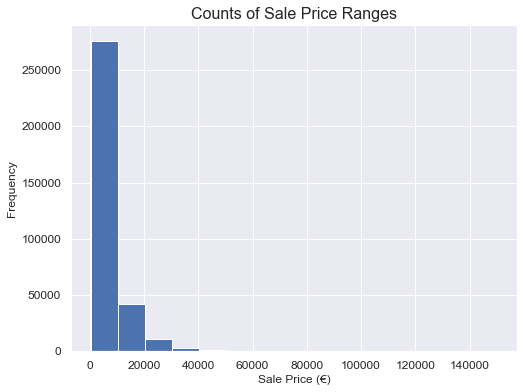

In [1789]:
size = 12
plt.figure(figsize=(8,6))
plt.title("Counts of Sale Price Ranges", size = 16)
plt.xlabel("Sale Price (€)")
plt.ylabel("Frequency",)
plt.xticks(size = size)
plt.yticks(size = size)
df["price"].hist(bins = 15);

There are cars that a worth more than 150,000 euro and after further inspection they do look legitimately priced as they are exotic or luxury cars. Since most of the data is clustered toward the low end of the price range (between 5,000 - 10,000 euros) we decided to only focused on vehicles between 500 euro and 20,000 euro. We have a considerable range in the quality of automobiles in our dataset. Only the lower range we have cars that could be consdiered "junkers" all the way up to luxury automobiles. However, the collectors items are the outliers in the dataset and we felt they could be included up until a certain point, there were only 232 cars priced over 150,000 so we decided to establish our max price there. Max price may be reduced if we observe poor RMSE scores. The metric RMSE is greatly affected by outliers and this is something to be aware of once we begin modeling. 

In [1790]:
adjusted_price = np.log(df['price'])

We created a variable to look at the logarithmic values of our target variable price. Because our linear scale is right skewed we hope to observe more of a normal distribution with our logarithmic scale prices.  

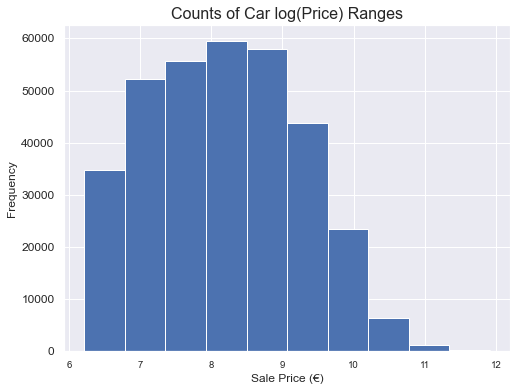

In [1791]:
size = 12
plt.figure(figsize=(8,6))
plt.title("Counts of Car log(Price) Ranges", size = 16)
plt.xlabel("Sale Price (€)")
plt.ylabel("Frequency")
plt.xticks(size = size * 4/5)
plt.yticks(size = size)
adjusted_price.hist(bins = 10);

We wanted to assess the log prices of the used cars in the data set. Logarithmic price scales are better than linear price scales at showing less severe price increases or decreases. Doing a log transformation on the data may give us better results on linear models. It makes the data more "normal". This is especially true when the data has outliers. 

### Kilometers Driven

Kilometers is the distance the car has been driven. This is an important feature and is usually one of the first questions asked when someone is buying a usedcar. Upon reviewing the values in the kilometers column it appears the number of kilometers driven is categorized by in increments of 10,000 up until 100,000 where it then increases by 25,000. This is not the traditional way to list the kilometers driven on a car. Usually the number is taken right from the odometer and it is an exact figure. Additonal research into the way the data was collected does not provide a further explanation of why the kilometers were recorded this way. We believe the kilometers on each car listing was rounded to the nearest 10,000 and nearest 25,000 for values above 100,000. An exact figure for distance driven would have been preferable but we will have to work with what we have, especially because this feature is likely to have a strong linear realtionship with price.

In [1792]:
print(f'Mean Kilometers Driven: {df.kilometer.mean()}')
print(f'Median Kilometers Driven: {df.kilometer.median()}')
print(f'Max Kilometers Driven: {df.kilometer.max()}') 
print(f'Min Kilometers Driven: {df.kilometer.min()}')

Mean Kilometers Driven: 125204.81216105765
Median Kilometers Driven: 150000.0
Max Kilometers Driven: 150000
Min Kilometers Driven: 5000


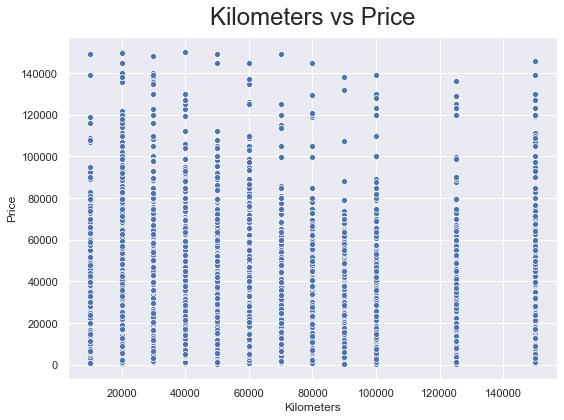

In [1810]:
plt.figure(figsize=(8,6))
plt.title("Kilometers vs Price", fontsize = size * 2, pad = size)
g = sns.scatterplot(df["kilometer"], df["price"]);
g.set_xlabel("Kilometers", size = 12)
g.set_ylabel("Price", size= 12)
plt.tight_layout()

Because the number of kilometers driven has been divided up into buckets and not given in exact numbers it makes it harder to visualize a trend using a scatterplot. A downward trend in price as kilometers driven increased is what we expected to see. However we observe prices widely ranging from cars with 20,000 kilometers all the way up to 140,000. This is a result of having a large number of car listings coupled with the fact that there is a wide range in car brands that range from luxury to smaller basic cars with retail prices on the low end. We have such a diverse make up in cars in the data that we are starting to observe a trend that prices range widely with every feature and we do not observe many of the trends we anticipated when starting this project. 

### Year of Registration

Below we wanted to identify any outliers in the dataset and decided to drop any cars with a year of registration before 1970. There were only 1,197 cars that were registred before 1970 and did not feel dropping these rows would have a great impact on our results. Additonally cars after were dropped from the dataset because the data was obtained in 2017 making it unlikely that there would be cars unreleased to the public in the data. 

In [1798]:
df[df['year of registration'] < 1970].shape

(1197, 21)

Looking to set a threshold for maximun age we identify the amount of cars listed that had a year of registration before 1970. This shows there are only 1,197 cars registered before 1970. We will only be losing a samll amount of data by setting our max age here.

In [1799]:
df[df['year of registration'] > 2017].shape

(3733, 21)

The data was collected in 2017, it is possible that there are some 2018 models in our data set as new releases come out the previous year. However, we can't say with certainty that this is the case so we will remove all car listings after 2017. We only drop 3,733 car listings by setting are minimum age here, which will not impact are data to the point were it is not adaquate for modeling purposes.

In [1801]:
df = df[df['year of registration'] > 1970]

In [1802]:
df = df[df['year of registration'] < 2018]

The feature year of registration is when the vehicle was first purchased and registerd with the motor vehicle regulatory body. We will identify approximately how old the vehicles were when this data was obtained by subtracting the year of registration from the year of registration. We create this new column through feature engineering and drop year of registration from the data. 

In [1803]:
df['age'] = 2017 - df['year of registration']

In [1804]:
df.drop(columns = 'year of registration', inplace = True)

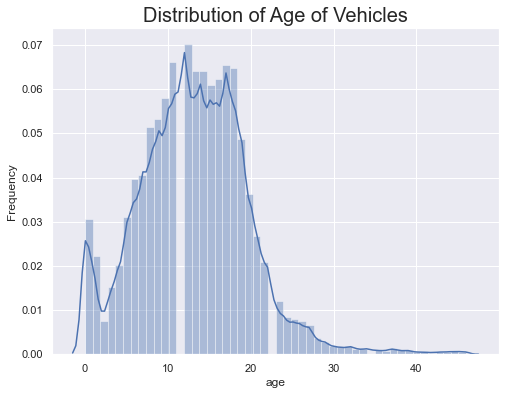

In [1805]:
plt.figure(figsize=(8,6))
sns.distplot(df['age']).set_title('Distribution of Age of Vehicles', size = 20)
plt.ylabel('Frequency');

Above we see the distribution of ages of car listings in the data. Teh line running through each bar is the kernel density estimation (KDE) which creates a curve of the distribution. The curve is calculated be weighing the distance of all the points in each specific location along the distribution. 

Year Of Registration is the year the car was first registered. We can infer from this information that this is the approximate age of the car. The year of registration will be subtracted from the year the data was collect (2017) to create an age feature in our dataset. The dataset included some outliers that we knew not to be true, such as cars listed from the year 1400 or 8455. These extremes could be removed because cars were not around in the 15th century and it is unlikely we would have cars from the future available on this list of pre-owned vehichles. There were cars that dated back to the early 20th century. However we will exclude cars before 1970 as it was only a small percentage of our dataset and these cars may be antiques or classics that may throw off our predicitons. This dataset is primarily focused on your typical used automobile that the average person would drive. We want to reduce the number of exotic or antique cars to get a better predicitons. 

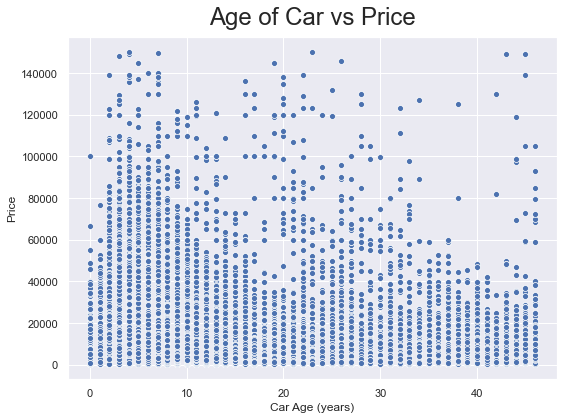

In [1806]:
plt.figure(figsize=(8,6))
plt.title("Age of Car vs Price", fontsize = size * 2, pad = size)
g = sns.scatterplot(df["age"], df["price"]);
g.set_xlabel("Car Age (years)", size = 12)
g.set_ylabel("Price", size= 12)
#g.tick_params(labelsize=18)
plt.tight_layout()

The above scatterplot shows a downward trend in price of cars with an increase in age. We do observe some older cars (40+ years) that have higher prices but these are most likely rare cars or antiques that are sold as collectors items. We observe high priced cars at almost every age between 0-40 years but we observe these expensive cars with less frequency with an increase in the age of a car.  

## Power PS

Although it’s still commonly used by carmakers, PS or Pferdestärke (horse strength in German) was actually replaced by kW as the EU's ‘legal’ measurement of engine power in 1992.  One PS is about 98.6% of a brake horsepower – the two are virtually interchangeable, and PS is sometimes referred to as 'metric horsepower'. We will convert the power ps category to kilo watts. 



In [1811]:
df[df['power ps'] == 0].shape

(26670, 21)

A car will have some 'power ps', it is impossible that a car have a 0 power ps as it would not be able to generate any power to propel itself. Listings with 0 power ps will be dropped. 

In [1812]:
df[df['power ps'] > 1000].shape

(233, 21)

It is possible for a car to have over 1,000 'power ps' but this is usually only the case in racing cars. We don't think cars with this amount of power a reprsentative of a typical used car. The maximum threshold will be set at 1,000, which only excludes 233 listings from the data.

In [1813]:
df = df[(df['power ps'] < 1000) | (df['power ps'] > 0)]

In [1814]:
df['kw power'] = df['power ps'] * 0.7355

power ps is converted to kw power which is the standard measurent of a car's power in the EU. This is also a more familiar unit of power than power ps. 

In [1815]:
df.drop(columns = 'power ps', inplace = True)

power ps is dropped from the datast now that we have featured engineered the category kw power. 

## Address Null Values

All of the categories that have null values are categorical features. The first feature we wanted to address was model. We reviewed the value counts of each model for each brand and used the mode to to replace the missing data. The feature model had null values that was just over 5%. This is usually the threshold to just drop the missing data, but we wanted to replace the null values with the mode to see it's performance on the model. We will then remove these imputed values and run the model again to see which performs better. 

#### Model Null Values

We will impute missing model types from our dataset with the mode value of each brand. For Volkswagen missing model types will be imputed with the moddel golf. In this situation with the missing data we have this is the best method to fill null values as opposed to dropping the data completely. 

In [1816]:
vtype_mode = df.groupby('model')['vehicle type'].agg(pd.Series.mode)

In [1818]:
for i,vtype in vtype_mode.iteritems():
    if len(vtype) == 2:
        print(i,vtype)
    

#vtype_mode.replace(np.array(['kleinwagen', 'limousine']), 'limousine').value_counts()

elefantino ['kleinwagen' 'limousine']
superb ['kombi' 'limousine']


above we created a variable vtype_mode which is the mode value of the vehicle types in the dataset. This value will be used to impute the missing data for vehicle types. We observed array's in the dataset, which will cause problems during the modeling phase. Models cannot accept array's which are a list of indiviudal strings. We had to create a for loop to look through our data and locate the arrays. Once they were located we replaced those arrays with individual strings, which you will see in the cell below. 

In [1819]:
vtype_mode['elefantino'] = 'limousine'
vtype_mode['superb'] = 'limousine'
vtype_mode['serie_2'] = 'suv'

In [1820]:
df['vehicle type'].fillna(df['model'], inplace = True)

In [1821]:
df['vehicle type'] = df['vehicle type'].map(vtype_mode.to_dict()).fillna(df['vehicle type'])

the feature vehicle type's null values are filled with the mode value of the vehicle types in our dataset. After intially dropping these values we want to see if our scores will increase by keeping this data in the dataset. 

In [1822]:
brand_mode = df.groupby('brand')['model'].agg(pd.Series.mode)

In [1823]:
df['model'].fillna(df['brand'], inplace = True)

In [1824]:
df['model'] = df['model'].map(brand_mode.to_dict()).fillna(df['model'])

The null values in the feature model are imputed with the mode value of each model for every brand of car. We identified the mode value for each brand (i.e. golf for Volkswagen) and imputed this value to every listing that did not have any data in this column.

In [1825]:
df[df['brand'] == 'sonstige_autos']['model'] = 'andere'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Sonstige autos is the German term for other cars. For consistency with other data we changed this to andere which is the German word for other and is more commonly used in other categories throughout the dataset. 

#### Pictures of Car

Pictures of car column did not have any data. It appears there was an error when scraping the information from the website. This column will be dropped from the data. 

In [1826]:
df.drop(columns = 'pictures of car', inplace = True)

#### Fuel Type & Gearbox

Fuel type and gear box (aka transmission types) were two of the five categories with missing data. Below we identify the modes of both features and will impute the modes of both variable for the missing values. Again, we feel the data we have is valuable and do not want to drop it completetly from the dataset. 

In [1828]:
df[['gear box', 'fuel type']].mode()

,gear box,fuel type
0,manuell,benzin


Identify the modes of the gear bos (transmission types) and fuel type features. The mode values will be used to impute the missing data. 

In [1829]:
df['gear box'].fillna(df['gear box'].mode().values[0], inplace = True)

In [1830]:
df['fuel type'].fillna(df['fuel type'].mode().values[0], inplace = True)

Imputed mode values of gearbox also known as transmission types. Manual transmissions were by far the most common transmission type so this was our best method to address the null values. Also there are only two types of transmissions so imputing the wrong value is less likey. This is not ideal to address null values but we don't want to just drop data from our dataset. 

#### Unrepaired Damage

If the car has  damage which has not repaired yet been repaired. This is a feature that could greatly impact the re-sale value of a car and is something that most likely cannot be hidden from a potential buyer. To address the null values in this category we will assume a null value means there is no un-repaired damage and the value will be filled with the answer 'nein' (no). If did not have any damange and thus did not need repair it is likely a seller ommitted an answer all together from this category. 

In [1831]:
df['unrepaired damage'].unique()

array(['ja', nan, 'nein'], dtype=object)

We identify the unique values in the unrepaired damage column. The seller either listed ja (yes) or nein (no) or left the answer blank. 

In [1832]:
df['unrepaired damage'].value_counts()

nein    247629
ja       26038
Name: unrepaired damage, dtype: int64

We get a count of the number of responses for this category. Responding no to this question was much more common that responding yes. This makes sense as most people would not allow damage to go unrepaired on their vehicles. 

In [1833]:
df['unrepaired damage'].fillna('nein', inplace = True)

The null values in the unrepaired damage column are filled with the mode value nein (no).

#### Seller

In [1834]:
#gewerblich/commercial(english) all other sellers are private 
df.groupby('seller').size()

seller
gewerblich         1
privat        325667
dtype: int64

Seller types features shows if the person selling the car is a private seller or a commercial seller (Gewerblich is the German word for commericial). All but one of the sellers in the dataset is a private seller. This column will be dropped as it will not be able to provide us information on the relationship between seller and price because all but one seller is a private seller. 

### Vehicle Type

The column vehicle type classifies each listed vehicle by body style. Governments and private organizations have developed car classification schemes that are used for various purposes including regulation, description and categorization fo cars. This feature is likely to have some linear relationship to price as compact cars (klienwagen) are smaller cars with smaller engines which are likely to cost less than a sedan or SUV.

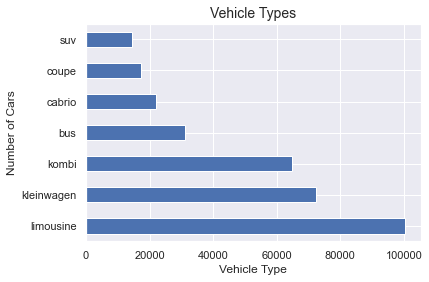

In [1835]:
df['vehicle type'].value_counts().plot(kind = 'barh')
plt.title('Vehicle Types', size = 14)
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Cars');

__English Translations__ 

Limousine - Sedan

Kleinwagen - Compact Car

Kombi - Minibus

Cabrio - Convertible 

Andere - Other




The most common vehicle types in the data set are Sedans and compact cars. Europeans tend to drive smaller more fuel efficient cars because of the price of fuel in Europe is more expensive than the United States. We observe a small number of SUV's and no pickup trucks. 

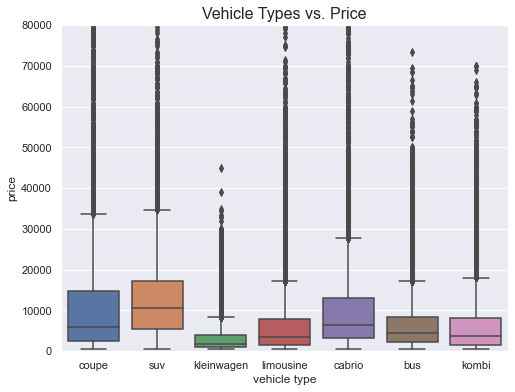

In [1836]:
var = 'vehicle type'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
plt.title("Vehicle Types vs. Price", size = 16)
fig.axis(ymin=0, ymax=80000);

Again we see a vast range of prices from somewhere in the low hundreds all the way up to 100,000. The box plots help visualize that most of the vehicle types listed have prices that are clustered below the 20,000 euro ranges. We can infer from the box plot that SUV's have the highest re-sale prices while the small compact car (kleinwagen) have the lowest retail price.

## Car Brands

Brand of car is likely to be an important feature in our model. There are certain brands in the dataset that can be considered luxury brands. Brands like Audi, BMW, and Mercedes-Benz are likely to cost more on average than many of the other brands in the data. There are likely to be brands that are less expensive and it is important to analyze what brands make up the data and how these brands are priced. 

In [1837]:
top_10_brands = df.brand.value_counts().head(10)

In [1838]:
new_labels = ["Volkswagen","BMW","Mercedes Benz","Opel","Audi","Ford","Renault","Peugeot","Fiat","Seat"]

In [1839]:
top_10_brands.index = new_labels

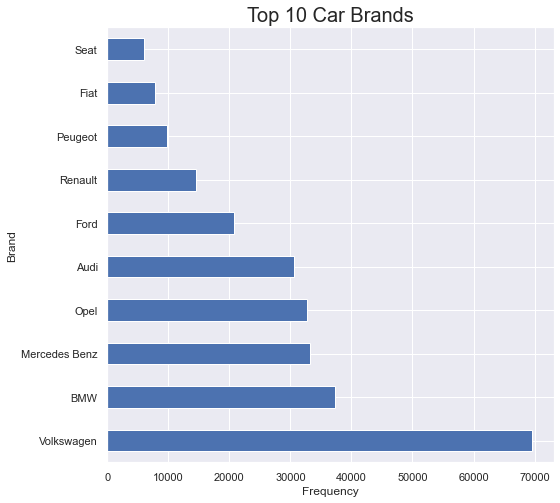

In [1840]:
#Visualize the frequency of brands in the dataset (add labels)
plt.figure(figsize = (8,8))
top_10_brands.plot(kind = 'barh')
plt.title('Top 10 Car Brands', size = 20)
plt.xlabel('Frequency')
plt.ylabel('Brand');

It comes as no surprise that four of the five most common brands are German manufacturers as this data was scraped from a German website. Volkswagen is the most common car making up approximately 20% of our dataset. Volkswagen roughy translages to the peoples car and this makes sense now as we see how popular of a car it is with German consumers. Volkswagens are affordable and reliable cars that have good fuel economy, which is very important to European consumers because of the price of gas in Europe. We only observe one car brand that comes from outside of Europe in the top 10. Ford ranks sixth on this list and outside research shows Ford has a large presence in Germany with a factory in Cologne. Fords are one of the most popular foregin (outside of Europe) car makers in Germany. 

In [1841]:
mean_price_brand = df.pivot_table(index = 'brand',
                          values = 'price', aggfunc = np.mean)

In [1842]:
new_labels = ["Volvo","Volkswagen","Trabant","Toyota","Suzuki","Subaru","Sonstige Autos","Smart","Skoda","Seat",
             'Saab', 'Rover', 'Renault', 'Porsche', 'Peugeot', 'Opel', 'Nissan', 'Mitsubishi', 'Mini', 'Mercedes Benz',
             'Mazda', 'Land Rover', 'Lancia', 'Lada', 'Kia', 'Jeep', 'Jaguar', 'Hyundai', 'Honda', 'Ford', 'Fiat', 
              'Daihatsu', 'Daewoo', 'Dacia', 'Citroen', 'Chrysler', 'Chevrolet', 'BMW', 'Audi', 'Alfa Romeo']

Above we calculate the mean price of all the car brands in our data set and create a spreadsheet-style pivot table which will be used in a visualization to show the mean prices of the car brands we will be introducing into our model. New labels were also applied above to this column of data to make our visualization easier to read. 

In [1843]:
mean_price_brand.index = new_labels

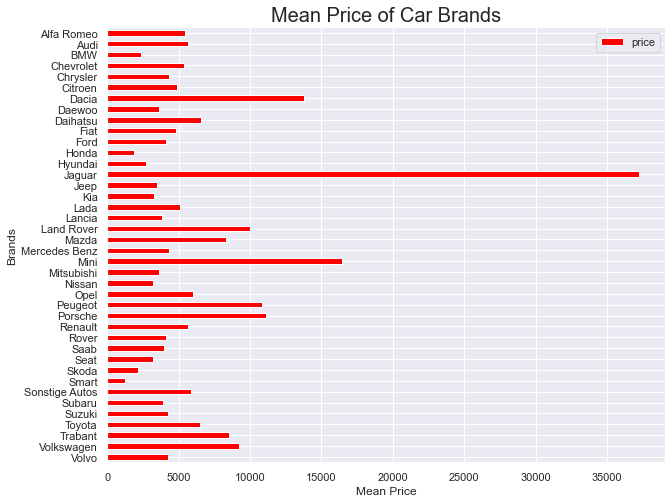

In [1844]:
mean_price_brand.plot(kind = 'barh', color = 'red', figsize = (10 ,8))
plt.title('Mean Price of Car Brands', size = 20)
plt.ylabel('Brands')
plt.xlabel('Mean Price');

Above we obeserve the mean prices of the brands of vehicles in our data set. Most of the brands mean prices are below €10,000. Only two brand Land Rover and Porsche have mean values of over €15,000. Even other luxury brands like BMW and Audi have low mean prices. This is not surprising as consumers of used cars are probably not interested in spending more than €10,000. At that point you start to enter the new car price range. We also observe many of the smaller less know brands with low mean prices under €5,000. We may want to group car brands into three separate tiers based on mean price to engineer another feature to include in our model. 

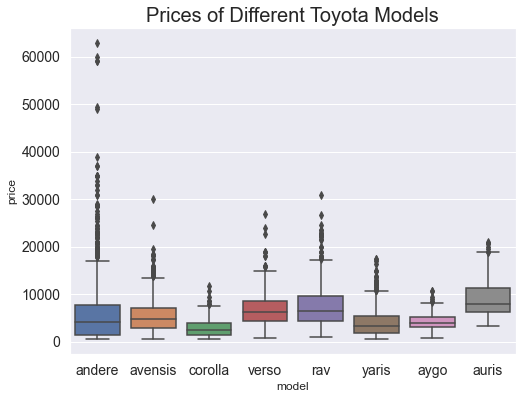

In [1845]:
size= 14
plt.figure(figsize=(8,6))
sns.set(style='darkgrid')
sns.boxplot(x='model', y='price', data=df[df.brand == 'toyota']).\
set_title('Prices of Different Toyota Models', size = 20)
fig.axis(ymin=0, ymax=80000);
plt.xticks(rotation=0, size = size)
plt.yticks(size = size);

The above box plot shows the prices of the Toyota models in the dataset. This brand like most of the other brands in our data have a great range in price. This is most likely due to the age, number or kilometers and condition of the cars. This brand is considered luxury and some models can retail for over €60,000. However, most of the mean averages for this brand is below €10,000. This is what makes the resale value of cars interesting as they are a depreciating asset and it is difficult to maintain their value. We observe in the above visualization the values for cars from the start of their life cycle until the end. Each model shows outliers that represent prices that are very close to that models retail price and from there prices all the way down to around a €1,000. The majority of the car prices are within are in the low to mid thousands as shown in the box plots above. 

Automobiles are depreciating assets so as soon as they are purchased and driven off the lot their price begins to drop. Increasing the mileage as well as addtional wear and tear to a vehicle are contributing factors to price depreciation. This is why we observe this range of prices

### Fuel Types

Fuel type is a feature on a vehicle that is likely to have an impact on the price. A vehicle that requires diesel is usually a larger automobile that has more power. Vehicles that use diesel are usually trucks and buses. Diesel fuel is generally more expensive than gasoline and the engines can last much longer than a gasoline powered engine. This is an important feature to analyze in order to understand what types of fuel the cars in our dataset run on and the frequency of those fuel types. 


__English Translations__ 

benzin - gasoline

elektro - electric

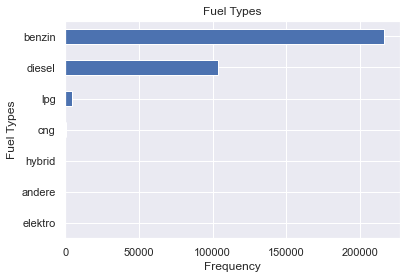

In [1846]:
df['fuel type'].value_counts(ascending = True).plot(kind = 'barh')
plt.title('Fuel Types')
plt.xlabel('Frequency')
plt.ylabel('Fuel Types');

Gasoline and diesel and the most common fuel types of the cars in the dataset. Research shows that diesel cars cost more in comparison to gas powered cars and have a higher resale value. Gasoline and diesel cars make up the majority of fuel types in the dataset, representing over 300,000 of the 370,000 rows. 

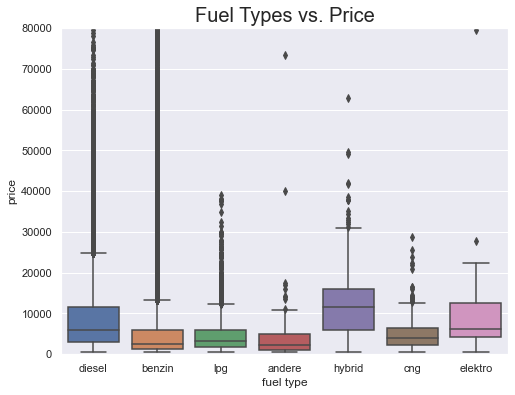

In [1847]:
#Title!!!
var = 'fuel type'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
plt.title('Fuel Types vs. Price', size = 20)
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=80000);

__English Translations__ 

benzin - gasoline

elektro - electric

lpg - liquid natural gas

cng - compressed natural gas

Again we see a vast range of prices from somewhere in the low hundreds all the way up to 100,000. The box plots help visualize that most of the vehicle types listed have prices that are clustered below the 20,000 euro ranges. We can infer from the box plot that vehicles with hybrid fuel types have the highest re-sale prices. For gasoline (benzin) which is the most common fuel type in our data set we observe a mean value in the low thousands and the third quartile range in the mid thousands and a maximu of approximatley 14,000 euros. Outliers continue all the way up to the ymax setting of the box plot. The graph shows us again the large number of outliers in the dataset. The same observation for gasoline engines is observed for diesel, the second most common fuel type. The other fuel types make up only a small percentage of total fuel types but they follow similar patterns as gasoline and diesel engines.  

### Transmission Type

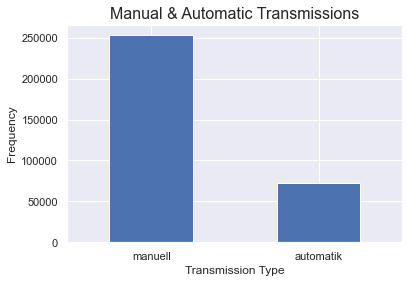

In [1848]:
df['gear box'].value_counts().plot(kind = 'bar')
plt.title('Manual & Automatic Transmissions', size = 16)
plt.xlabel('Transmission Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency');

Manual cars are about $1,000 cheaper than automatics on average, as of 2019. In addition, older manuals have a greater fuel economy than automatics of a similar age. That's not just because manual cars lack fuel-draining torque converters. It's also because manual cars have lighter transmissions. Manual transmissions are much popular in Europe which is were this data is derived from. 

In [1849]:
gb_pvt = df.pivot_table(index = 'gear box',
                          values = 'price', aggfunc = np.mean)

In [1850]:
new_labels_ = ['Automatic', 'Manual']

Above we created new labels for the bargraph with the appropriate english translations

In [1851]:
gb_pvt.index = new_labels_

<Figure size 1152x648 with 0 Axes>

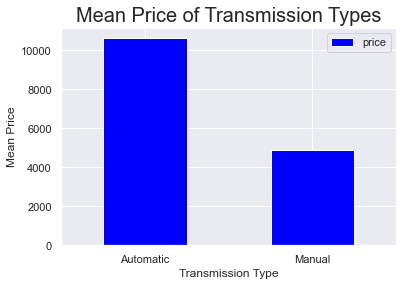

In [1852]:
plt.figure(figsize =(16, 9))
gb_pvt.plot(kind = 'bar', color = 'blue')
plt.xlabel('Transmission Type')
plt.ylabel('Mean Price')
plt.xticks(rotation = 0)
plt.title('Mean Price of Transmission Types', size = 20);

Mean prices of automitic cars is about 5,000 euro more than manual cars. However, automatic cars are much rarer in our dataset. Outside research shows on average manual cars are approximately 1,000 euro less than manual cars. This does not apply in our data as there is a considerable difference in price for this feature. The automatic transmissions are much less common and more expensive in our data. This may be due to buyers who have more money to spend on a car and want certain specifications like an automatic transmission. 

### Damage To Vehicle

Unrepaired damage means there is damage to the vehicle that has not been repaired. This feature will likely negatively affect the price of a car. We want to assess how often damaged cars and whether they have been repaired or not occur in the dataset. 

This can be an important factor when considering its affect on price but we do not know the extent of repairs or damage when looking at this feature. Ideally we would be able to gather more information on the extent of damange an group damage into categories, like minor damage, medium damage, or severe damage. 

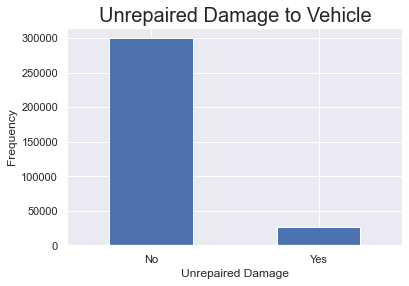

In [1853]:
damage = df['unrepaired damage'].value_counts()
damage_labels = ['No', 'Yes']
damage.index = damage_labels
damage.plot(kind = 'bar')
plt.title('Unrepaired Damage to Vehicle', size = 20)
plt.xlabel('Unrepaired Damage')
plt.xticks(rotation = 0)
plt.ylabel('Frequency');

A small number of vehicles in our data set have unrepaired damange, which will likely have a negative impact on the price of a car. Damage could range from a minor dent to severe damage to the body of a car. Without having specifics it will be difficult to understand the true impact this feature will have on price.  

### EDA summary 

After analyzing the features we believe will have the greatest correlation to price we can say with some confidence that we will be able to answer the problem in question, which is to accurately predict the resale prices of used cars. There is some concern about the number of outliers in our dataset but because so much of the data is clustered on the lower end of the price range we may be able to avoid any issues with outliers. Scaling back on max price may be done to eliminate outliers so we can focus on a smaller range in price. Outside research shows that the average consumer would not be looking for a used car priced above €20,000 because at this threshold most people would look toward a new car. 

### Revisting Max Price

After running models with a max price of €150,000 we observed RMSE scores above our baseline score. We believed the outliers in the data were having a sizeable affect on our models performance. We keep reducing the price until we were able to see RMSE scores drop below the baseline score.Price max reduced to €20,000 as model scores were performing poorly, returning results worse than our baseline model. 70%+ of our data was within this range so there is still a sufficient amount of data for prediction. 

In [1233]:
df = df[df['price'] <= 20_000]

In [1234]:
print(f'Mean Price of Cars: {df.price.mean()}')
print(f'Median Price of Cars: {df.price.median()}')
print(f'Max Car Price: {df.price.max()}') 
print(f'Min Car Price: {df.price.min()}')

Mean Price of Cars: 4901.359352097579
Median Price of Cars: 3200.0
Max Car Price: 20000
Min Car Price: 500


Lowering the maximum price to 20,000 has pushed the mean down to €4901.36

In [1797]:
df.shape

(330826, 21)

Limiting the max pirce ot €20,000 dose not reduce our data to a point that would cause concern. We still maintain over 300,000 used car listings. 

## Preprocessing

We will need to one hot encode our categorical features. These include vehicle type, gear box, fuel type, brand and unrepaired damage

In [1237]:
df = pd.get_dummies(data = df, columns=['vehicle type',
                                       'gear box',
                                       'fuel type',
                                       'brand',
                                       'unrepaired damage',
                                        ], drop_first = True )

In [1249]:
X = df.drop(columns = ['date crawled', 'name', 'seller','AB test', 'offer type', 'price','last seen',
                       'date created', 'ad duration', 'postal code', 'model'], axis = 1)
y = df['price']

Above we drop all the features we do not want to introduce into our models. y is our target variable price. 

## Train Test Split

In [1602]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y, random_state = RANDOM_STATE)

We perfom a train/test split on the dataset. We split our data into two pieces:

"A Training Set": The subset of the data on which we fit our model.

"A Testing Set": The subset of the data on which we evaluate the quality of our predictions.

In [1252]:
# Code adapted from DSI-11 Local FAQ, https://git.generalassemb.ly/DSI-US-11/local_faq/blob/master/code/custom_cross_val_score.ipynb

def rmse(y_true, y_pred): 
    '''Returns the root mean squared error'''
    return np.sqrt(mean_squared_error(y_true, y_pred))

We will use the above function to generate the RMSE score to evaluate all of the models we implement going forward. 

## Modeling

## Baseline Model

In [1402]:
baseline = DummyRegressor(strategy = 'mean')
baseline.fit(X_train, y_train)
baseline_preds_train = baseline.predict(X_train)
baseline_preds_test = baseline.predict(X_test)

In [1403]:
print('Training RMSE:',rmse(y_train, baseline_preds_train))
print('Testing RMSE:',rmse(y_test, baseline_preds_test))
print(f'Cross Validation Score:', cross_val_score(baseline, X, y, scoring=make_scorer(rmse), cv=5).mean())

Training RMSE: 4522.340583950257
Testing RMSE: 4491.613148683399
Cross Validation Score: 4514.667324642114


A baseline model has been created using the mean sale prices of our target variable price. This model provides a useful point of comparison for all future models used. Once we start getting results from other models our baseline can tell us if a change is adding value or if we need to include different features. If the model achieves a a score that is above the baseline prediction we will know something is wrong and that this model may not be appropriate for our problem. The baseline model is a critical component of our modeling process. We will be using the metric RMSE to score our models performance. The RMSE of our baseline model is €4,522.34(training RMSE) and €4,491.61(testing RMSE). This score shows the baseline model's predictions are incorrect by a large margin.

## Linear Regression

In [1603]:
model = LinearRegression()

In [1604]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1605]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

In [1606]:
print(f'Training RMSE:', rmse(y_train, y_train_preds))
print(f'Testing RMSE:', rmse(y_test, y_test_preds))
print(f'Cross Validation Score:',cross_val_score(model, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 2983.801463621965
Testing RMSE: 2954.702751072221
Cross Validation Score: 2977.574367447824


The Multiple Linear Regression Model perfoms better than the baseline model which had an RMSE score of 4,491.61. However, the scores of this model are poor. The RMSE score is 2983.801 on the training data. With the average price of a car being 4901.35 this is a considerable amount to be off by. These scores are indicative of an underfit model.  The model seems to suffer from high bias, it is failing to capture the underlying trend in the data. A positive aspect of these scores is is shows that this model is not overfit. An overfit model performs well on the data it is trained on but generalize poorly to any new data. The testing and training scores are very close which means that we have a low amount of variance in our model.  This is the first model we will be using and hopefully the scores will improve from here. 

## Ridge

In [1870]:
#create variable for Sklearn StandardScaler to be used in Ridge and Lasso Models 
ss = StandardScaler()

ss.fit(X_train)

X_train_sc = ss.transform(X_train)

X_test_sc = ss.transform(X_test)

In [1871]:
#create alphas to be cross-validated over 
r_alphas = np.logspace(1,5,100)

In [1872]:
ridge = RidgeCV(alphas = r_alphas, cv = 5)

In [1873]:
ridge.fit(X_train_sc, y_train)

RidgeCV(alphas=array([1.00000000e+01, 1.09749877e+01, 1.20450354e+01, 1.32194115e+01,
       1.45082878e+01, 1.59228279e+01, 1.74752840e+01, 1.91791026e+01,
       2.10490414e+01, 2.31012970e+01, 2.53536449e+01, 2.78255940e+01,
       3.05385551e+01, 3.35160265e+01, 3.67837977e+01, 4.03701726e+01,
       4.43062146e+01, 4.86260158e+01, 5.33669923e+01, 5.85702082e+01,
       6.42807312e+01, 7.05480231e+0...
       1.70735265e+04, 1.87381742e+04, 2.05651231e+04, 2.25701972e+04,
       2.47707636e+04, 2.71858824e+04, 2.98364724e+04, 3.27454916e+04,
       3.59381366e+04, 3.94420606e+04, 4.32876128e+04, 4.75081016e+04,
       5.21400829e+04, 5.72236766e+04, 6.28029144e+04, 6.89261210e+04,
       7.56463328e+04, 8.30217568e+04, 9.11162756e+04, 1.00000000e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [1874]:
#Optomal value of alpha
ridge.alpha_

148.4968262254465

In [1875]:
y_train_ridge = ridge.predict(X_train_sc)
y_test_ridge = ridge.predict(X_test_sc)

In [1876]:
print(f'Training RMSE:', rmse(y_train, y_train_ridge))
print(f'Testing RMSE:', rmse(y_test, y_test_ridge))
print(f'Cross Validation Score:',cross_val_score(ridge, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 2983.805367830393
Testing RMSE: 2954.7040901159853
Cross Validation Score: 2977.5817788382765


Ridge Regression is A variation of linear regression with L2 regularization. Regularization adds penalty for higher terms in the model and thus controls the model complexity. If a regularization term is added, the model tries to minimize both loss and complexity of model. Limiting the complexity prevents the model from overfitting. Ridge model shrinks our regression coefficients closer to zero to make our model simpler. We are accepting more bias in exchange for a decrease in variance. We observe training and testing scores that are very close to the Linear Regression model. This is surprising as we would expect to see an improvement in the fitness of our model. We can infer from the scores so far that the model is having a difficulty making accurate predictions on the target variable price. There may be too many features that are not linearly realted which are adding noise to the model making it difficult to learn.

## Lasso

In [1619]:
#create list of alphas 
l_alphas = np.logspace(1, 3, 50)

In [1620]:
#Cross-validate over our list of lasso alpahs
lasso = LassoCV(max_iter = 50_000, alphas = l_alphas, cv = 5, random_state = RANDOM_STATE)

In [1621]:
# Fit lasso model with best ridge alpha
lasso.fit(X_train_sc, y_train)

LassoCV(alphas=array([  10.        ,   10.98541142,   12.06792641,   13.25711366,
         14.56348478,   15.9985872 ,   17.57510625,   19.30697729,
         21.20950888,   23.29951811,   25.59547923,   28.11768698,
         30.88843596,   33.93221772,   37.2759372 ,   40.94915062,
         44.98432669,   49.41713361,   54.28675439,   59.63623317,
         65.51285569,   71.9685673 ,   79.06043211,   86.85113738,
         95.40954763,  104.81131342,  115.13953993,  126.48552169,...
        294.70517026,  323.74575428,  355.64803062,  390.69399371,
        429.19342601,  471.48663635,  517.94746792,  568.9866029 ,
        625.05519253,  686.648845  ,  754.31200634,  828.64277285,
        910.29817799, 1000.        ]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=50000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
        verbose=False)

In [1622]:
# Optimal value of alpha
lasso.alpha_

10.0

In [1623]:
y_train_lasso = lasso.predict(X_train_sc)
y_test_lasso = lasso.predict(X_test_sc)

In [1624]:
print(f'Training RMSE:', rmse(y_train, y_train_lasso))
print(f'Testing RMSE:', rmse(y_test, y_test_lasso))
print(f'Cross Validation Score:',cross_val_score(lasso, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 2984.78204745922
Testing RMSE: 2955.526653126418
Cross Validation Score: 3012.5778657112824


Lasso is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the model. It uses shrinkage wherw data values are shrunk towards a central point, like the mean. We observe almost identical scores as the ridge regression model. The lasso model does not perform well with so many features in our model. If we were to reduce these features after assessing the strongest coefficeints the model may perform better. 

## Decision Tree

*Gridsearch only contains pre-determined best parameters to efficiently run notebook.

In [1722]:
dtr = DecisionTreeRegressor(random_state = RANDOM_STATE)

# create paramters
dtr_params = {
    'max_depth': [25],
    'max_features': [25],
    'min_samples_leaf': [20],
    'min_samples_split': [18],
}


 # Grid Search over parameters 
gs = GridSearchCV(dtr, param_grid=dtr_params, cv = 5, scoring = make_scorer(rmse))


In [1723]:
d_tree = gs.fit(X_train, y_train)

In [1724]:
d_tree.best_params_

{'max_depth': 25,
 'max_features': 25,
 'min_samples_leaf': 20,
 'min_samples_split': 18}

In [1725]:
dtree_train_preds = d_tree.predict(X_train)
dtree_test_preds = d_tree.predict(X_test)

In [1726]:
print(f'Training RMSE:', rmse(y_train, dtree_train_preds))
print(f'Testing RMSE:', rmse(y_test, dtree_test_preds))
print(f'Cross Validation Score:',cross_val_score(gs.best_estimator_, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 1759.730968485332
Testing RMSE: 1835.3372776048725
Cross Validation Score: 1863.981085585956


The first of the tree based models will will use is the decision tree model. The decision tree builds regression models in the form of a tree structure. It breaks down the dataset into smaller and smaller subsets while at the same time an assocaited decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. The decision tree model perfomed better than all of the linear regression models, achieving a training score below RMSE 2,000 at 1759.731. The testing score was RMSE 1835.337 which tell us this model is an increase in variance. We anticipate using a Random Forest model will reduce the variance and improve the RMSE scores.

## Random Forest

In [1702]:
rfr = RandomForestRegressor(random_state = RANDOM_STATE)

# construct paramters
rfr_params = {
    'max_depth': [20],
    'max_features': [18],
    'min_samples_leaf': [12],
    'min_samples_split': [10],
    'n_estimators': [50]
}

 # Perform Grid Search
gs_rfr = GridSearchCV(rfr, param_grid=rfr_params, cv = 5, scoring = make_scorer(rmse))


In [1703]:
rfr_ = gs_rfr.fit(X_train, y_train)

In [1704]:
rfr_.best_params_

{'max_depth': 20,
 'max_features': 18,
 'min_samples_leaf': 12,
 'min_samples_split': 10,
 'n_estimators': 50}

In [1705]:
rfr_train_preds = rfr_.predict(X_train)
rfr_test_preds = rfr_.predict(X_test)

In [1706]:
print(f'Training RMSE:', rmse(y_train, rfr_train_preds))
print(f'Testing RMSE:', rmse(y_test, rfr_test_preds))
print(f'Cross Validation Score:',cross_val_score(rfr_, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 1636.5573504518238
Testing RMSE: 1697.3264746042485
Cross Validation Score: 1714.619769344385


Random forest is an ensemble of randomized regression trees. Random Forests correct for decision trees' habit of overfitting to their training data. The RMSE training score from the random forest model was RMSE 1636.557 the testing score was RMSE 1697.326. This model has scored the best so far. The difference between the training and testing scores show that the random forest model has less variance than the decision tree model. 

### Extra Trees

In [1727]:
etr = ExtraTreesRegressor(random_state = RANDOM_STATE)

# construct paramters
etr_params = {
    'max_depth': [25],
    'max_features': [22],
    'min_samples_leaf': [18],
    'min_samples_split': [15],
    'n_estimators': [100]
}

 # Perform Grid Search
gs_efr = GridSearchCV(etr, param_grid=etr_params, cv = 5, scoring = make_scorer(rmse))

In [1728]:
gs_efr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param

In [1729]:
gs_efr.best_params_

{'max_depth': 25,
 'max_features': 22,
 'min_samples_leaf': 18,
 'min_samples_split': 15,
 'n_estimators': 100}

In [1730]:
y_train_pred_etr = gs_efr.predict(X_train)
y_pred_etr = gs_efr.predict(X_test)

In [1731]:
print(f'Training RMSE:', rmse(y_train, y_train_pred_etr))
print(f'Testing RMSE:', rmse(y_test, y_pred_etr))
print(f'Cross Validation Score:',cross_val_score(gs_efr, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 1951.16485232175
Testing RMSE: 1976.5788481223085
Cross Validation Score: 1989.9327709716313


With the Extra Trees model we observe reduced variance but an increase in bias. We observe an increase in score, (Training 1951.164, Testing 1976.579) but a decrease in the difference between the training and testing scores. This is the best fit model of the tree based models. 

## Gradient Boost

In [1732]:
params = {'n_estimators': 200, 'max_depth': 5,
          'learning_rate': 0.02, 'loss': 'ls'}


gbr = GradientBoostingRegressor(**params, random_state = RANDOM_STATE)

#Train the model
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.02, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1733]:
y_preds_train_gbr = gbr.predict(X_train)
y_preds_gbr = gbr.predict(X_test)

In [1734]:
print(f'Training RMSE:', rmse(y_train, y_preds_train_gbr))
print(f'Testing RMSE:', rmse(y_test, y_preds_gbr))
print(f'Cross Validation Score:',cross_val_score(gbr, X, y, cv = 5, scoring = make_scorer(rmse)).mean())

Training RMSE: 1934.727340370413
Testing RMSE: 1916.7629951665845
Cross Validation Score: 1936.5353170682756


Gradient Boosting Regressor: An ensemble method that combines many decision trees using boosting. Gradient boost achieved a lower testing score 1916.763 than training score 1934.727. This is the first time we observe this in any of the models. This tells us that the model is very well fit and is not being over fit on the training data. When it is introduced to the testing data it performs better. The scores are still higher than both the decision tree and random forest models. 

## Model Selection

|Model|Training RMSE Score|Testing RMSE Score|
|:---|:---|:---|
|Linar Regression|2983.801|2954.703|
|Ridge|2983.805|2954.704|
|Lasso|2984.782|2955.527|
|Decision Tree|1759.730|1835.337|
|Random Forest|1636.557|1697.326|
|Extra Trees|1951.164|1976.578|
|Gradient Boost|1934.727|1916.762|

All models performed better than our baseline model, however they all suffered from high bias. We can infer from this that the features we included are poor predictors of price of a used car. We were able to reduce variance by scaling back on certain features but the overall scores remained poor. The Random Forest model perfomed best with a training score of 1636.557 and a testing score of 1697.326. There was some concern about the amount of variance with the random forest model as we observed better fit models for both extra trees and gradient boost. Ultimately, we felt the amount of variance wasn't great enough to disqualify the random forest model from selection. The difference in scores reinforced our decision as the random forest model scores were approximately 300 less than extra trees and gradient boost. This model will be selected for further evaluation to better understand the impact of the features we selected for this model. 


## Model Evaluation

### Plotting Actual vs. Predicted Price

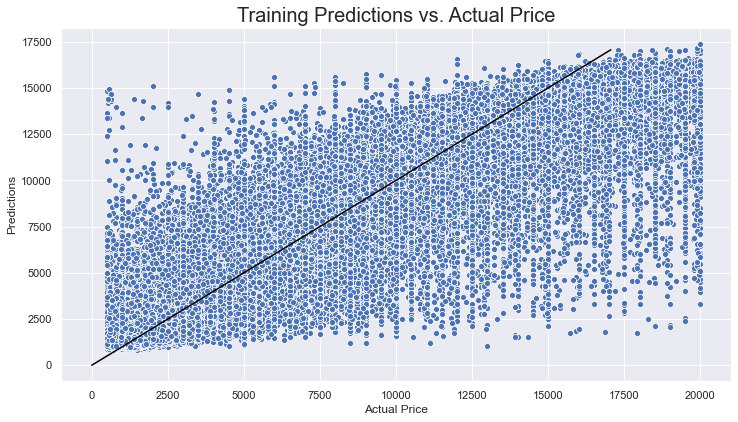

In [1563]:
plt.figure(figsize=(12,6.5))
sns.scatterplot(y_train, rfr_train_preds)
plt.title('Training Predictions vs. Actual Price', size = 20)
plt.xlabel('Actual Price')
plt.ylabel('Predictions')
plt.savefig('a.png')
plt.plot([0, np.max(y_preds_gbr)],
         [0, np.max(y_preds_gbr)],
         color = 'black');

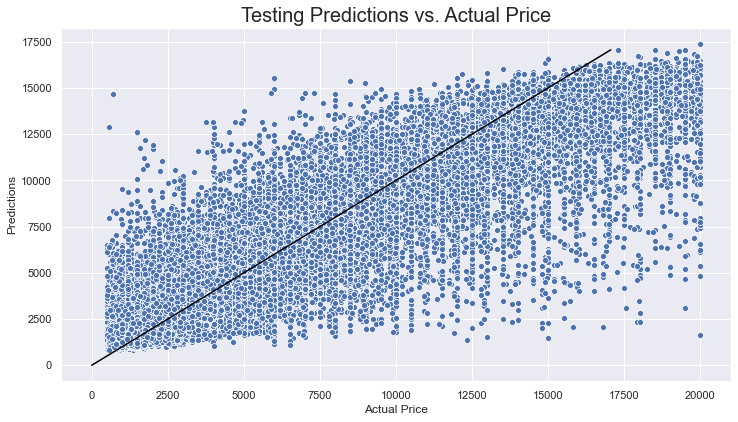

In [1564]:
plt.figure(figsize=(12,6.5))
sns.scatterplot(y_test, rfr_test_preds)
plt.title('Testing Predictions vs. Actual Price', size = 20)
plt.xlabel('Actual Price')
plt.ylabel('Predictions')
plt.savefig('a.png')
plt.plot([0, np.max(y_preds_gbr)],
         [0, np.max(y_preds_gbr)],
         color = 'black');

It is hard to tell because there a high volumne of plots in above scatterplot but we can say with confidence that we observe heteroscedasticity. These plots do not have a similar scatter and from lowest to highest price we observe predictions that are extremely far off from the actual price. We also observe a fan out effect of our plots especially as the true values increase in price. As price increases we observe many predictions that are much lower than the actual price of the car. We can see from this plot that the model struggled to make accurate predictions as the actual price of the car increased, prediciting much lower prices than the true price of the cars. If the predictions had better accuracy we would observe the plots to be more linear, clustered more closely to the black line on the graph. The above shows predictions that the model is performing poorly making a high number of predictions that are off a sizeable amount from the acutal price. 

### Residuals Plot

In [1579]:
#training and testing residuals created 
residuals_train = y_train - rfr_train_preds
residuals_test = y_test - rfr_test_preds

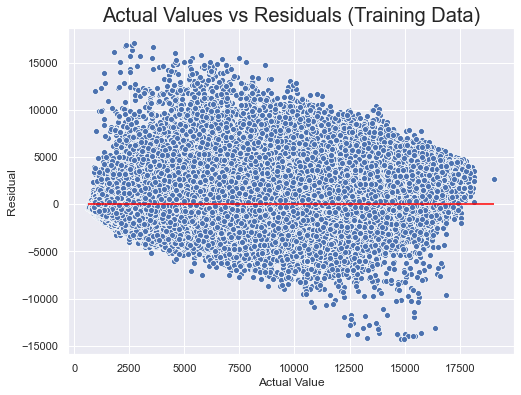

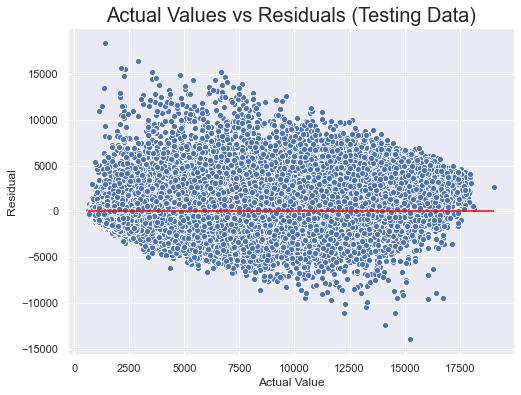

In [1740]:
plt.figure(figsize = (8, 6))
sns.scatterplot(rfr_train_preds, residuals_train)
plt.xlabel('Actual Value', size = 12)
plt.ylabel('Residual', size = 12)
plt.hlines(y = 0, xmin = min(rfr_test_preds), xmax = max(rfr_test_preds), color = 'red')
plt.title('Actual Values vs Residuals (Training Data)', size = 20);

plt.figure(figsize = (8, 6))
sns.scatterplot(rfr_test_preds, residuals_test)
plt.xlabel('Actual Value', size = 12)
plt.ylabel('Residual', size = 12)
plt.hlines(y = 0, xmin = min(rfr_test_preds), xmax = max(rfr_test_preds), color = 'red')
plt.title('Actual Values vs Residuals (Testing Data)', size = 20);



Above we plotted the residuals (errors) of the model against the actual values. As price increased we observe more residuals becoming negative. This shows the predictions were larger than the actual values. As actual prices increased the model had a more difficult time making accurate predicitons. We believe this stems from the fact that all brands had a great range in price. There may have been two cars that had similar features with very different prices due to additional variables that were not included in our models. This is furter confirmation that we had bad features that ultimated resulted to bad predictions.   

### Residuals Distribution 

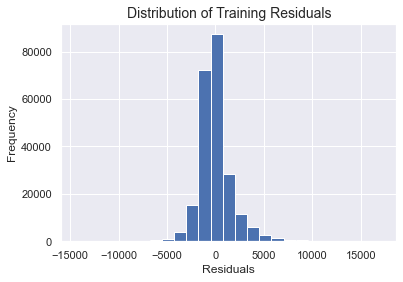

In [1417]:
plt.title("Distribution of Training Residuals", fontsize = 14)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
residuals_train.hist(bins = 25);

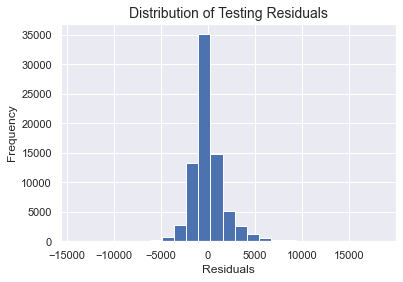

In [1418]:
plt.title("Distribution of Testing Residuals", fontsize = 14)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
residuals_test.hist(bins = 25);

The histograms above for both the training and testing residuals show the distribution of residuals being right skewed. However, it does seem so show approximate normality otherwise. The skewness can likely be attributed to the model having a tendency to over predict the target variable price. 

The assumption here is that residuals are normally distrubted around 0, have constant variance and are indpendent. We can say with some confidence that this assumption has not been violated. 

### Feature Importance

We cannot use coefficients to analyze feature importance from tree based models. Howe after a tree model is fit the model provides a feature_importances_ property that can be accessed to retrieve the relative importance scores for each input feature. Feature selection methods can give you useful information on the relative importance or relevance of features for a given problem. You can use this information to create filtered versions of your dataset and increase the accuracy of your models. Below we identify the top 10 features of 

In [1422]:
f_importance = gbr.feature_importances_

f_list=X_train.columns

df_feature_importance=pd.DataFrame(f_importance,columns=['importance'],index=f_list).sort_values(['importance'],ascending=False)

In [1425]:
f_list=X.columns
df_gbr = pd.DataFrame(f_importance,index=f_list,columns=['importance']).sort_values(['importance'],ascending=False)
top_10_features = df_gbr.head(10)

In [1444]:
feature_labels = ['Age', 'KW Power', 'Kilometer', 'Convertible','No Damage' , 'Diesel', 'Audi',
                 'Sedan', 'Mercedes Benz', 'Volkswagen']

In [1445]:
top_10_features.index = feature_labels

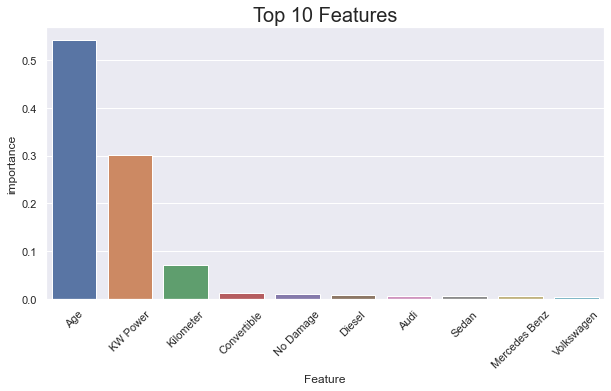

In [1446]:
#plot the feature importance
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(top_10_features.index,top_10_features['importance'],data=top_10_features)
plt.xlabel('Feature')
plt.title('Top 10 Features', size = 20)
plt.xticks(rotation=45);

Analyzing feature importance in relation to price we observe the two features we hypothesized would be the most important while doing our EDA in the top three. This comes as no surprise as intuition tells us that age and kilometers driven are the most important features when evaluating the re-sale value of a used car. Age seemed to be the most important factor. This is likely due to the fact that even if the odometer is realatively low on ab old car it just has had more time to wear. More things like rust, worn interior, outdated parts that may be hard to find are all contributing factors to price. Kilometers driven goes hand in hand with this, as mentioned in EDA there is a linear relation between these two variables. The older the car the higher the number on the odometer. 

The fact that Kilowatts is the second most important feature was somewhat surprising. At first it didn't make sense but after further research we learned that higher Kilowatts usually correlates to larger engine size. Engines being arguably the most important component of an automobile it is logical to assume that the larger the engine the higher the price of a car would be. Large powerful engines are also usually associated with luxury automobiles. 

## Interpretable Model/Model Coefficients

Additionally we wanted to analyze an interpretable model to gain a better understaning of the most important features when predicting price. Here we are able to intepret the models coefficients. A dataframe was collected of the 10 highest and lowest cofficients to see which features had the greatest impact on price of a used vehicle. 

In [1575]:
coef_df = pd.DataFrame((X_test.columns, model.coef_)).T
coef_df.rename(columns = {0: 'feature', 1: 'coefficient'}, inplace = True)
coef_df.sort_values(by = 'coefficient', ascending = False, inplace = True)

In [1549]:
top_10 = coef_df.head(10).sort_values(by = 'coefficient', ascending = True).reset_index().drop(columns = 'index')

bottom_10 = coef_df.tail(10).sort_values(by = 'coefficient', ascending = True).reset_index().drop(columns = 'index')

In [1556]:
#list of coefficients to be used as labels 
top_labels = ['Mercedez Benz', 'Coupe', 'No Unrepaired Damage', 'Convertible',
              'Audi', 'BMW', 'Jaguar', 'SUV', 'Mini', 'Porsche']
bottom_labels = ['Lada', 'Smart', 'Fuel Type-Electric', 'Dacia', 'Daewoo', 'Manual Transmission',
                 'Daihatsu', 'Sedan', 'Suzuki', 'Kia']

In [1557]:
#create readable labels for graph
top_10.index = top_labels 
bottom_10.index = bottom_labels

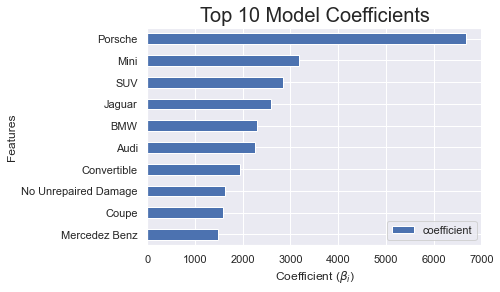

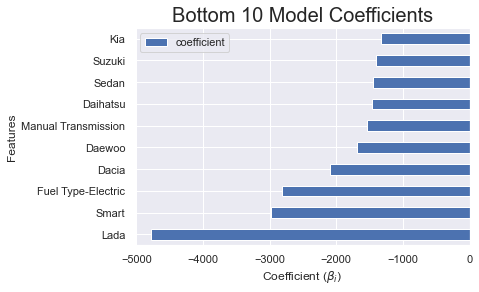

In [1578]:
top_10.plot(kind = "barh")
plt.title("Top 10 Model Coefficients", size = 20)
plt.xlabel("Coefficient ($\\beta_i$)")
plt.ylabel("Features");

bottom_10.plot(kind = 'barh')
plt.title("Bottom 10 Model Coefficients", size = 20)
plt.xlabel("Coefficient ($\\beta_i$)")
plt.ylabel("Features");

In regression with multiple independent variables, the coefficient tells you how much the dependent variable is expected to increase when that independent variable increases by one, holding all the other independent variables constant.

A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease. The coefficient value signifies how much the mean of the dependent variable changes given a one-unit shift in the independent variable while holding other variables in the model constant.

We analyzed the coefficents of the linear regression model to make direct coefficient interpreations which we can convey by direct increases or decreases in price (€). However, due to the poor performance of our models and the fact that there was no hypothesis testing these coefficeints cannot be trusted and instead give us an approximation of which features were the strongest coefficients. 

When analyzing the coefficients we see the car brand Porsche was the greatest positive coefficient. If the car was a porshce price increased by €6,677.86, all other factors held equal. If the vehicle was an SUV it would increase the price of a car by €2,851.07 all else being equal. 

For the negative coefficients we observe many of the smaller cars with lower retail prices. This makes sense as these cars had low mean price averages. Lada a Russian brand of car has the largest negative coefficent of -4,787.57.  If a car was a Lada price decreased by €-4,787.57, all other factors being held equal. The feature age had a coefficent of -214.94, which tell us that for every one unit increase in age (one year) the price of a vehicle decreased by €214.94.

Car brands seemed to be the strongest coefficients related to price. We do not see age or kilometers in the bottom ten coefficients which is surprisng becuase intution tells us that these factors would have the greatest impact on price. Luxury brands like BMW, Audi and Merceds-Benz had higher mean prices and more cars priced on the higher end of the price range which is most likely the reason we observe the coefficients shown above. The same thing goes for the car brands on the lower end where smaller more affordable cars have stronger negative coefficients. 

## Conclusion

Ones intuition regarding the sale price of a used car was reinforced through our predictions. We were able to identify age of a vehicle and the distance that it has been driven as being the most important factors related to the resale value of a car. Kilowatts the european equivalent of horsepower was also one of the most important features related to our target variable. We can infer from this that it is probably due to the size of the engine which is one of the most important components of an automobile. However, this may come as no surprise as the average person would probably assume engine size/power is an important factor in the price of a car. The reality of our predictive model demonstrates that cars have many nuanced features that affect the resale value of a car. The information that was provided in our dataset was not enough to make accurate predicitons even with what we would consider the most important features of a car. Also, a lot of noise was introduced with the model and brands of the cars for sale. A BMW 5 series had a mean price of 7,000 Euros but the prices ranged from just below 60,000 Euro down to 1,000 Euro. Based off of this information the model of the car introduces a lot of additional noise that may make it more challenging for the model to learn from. We observed this with the majority of makes and models with prices ranging from just below retail value to junk status. 

Based on our models performance it would not be effective in assisting buyers and sellers who are looking for additional appraisals on pre-owned vehicles. The predictions were too far off the acutal price for this to be an effective model. The best performing model was the random forest model (Training RMSE 1636.557, Testing RMSE 1697.326), which is approximately 20% of the mean value of the prices of cars in our dataset. If this model was put into use buyers and sellers would run the risk of overpaying or selling below the fair market value by a considerable amount. Straight line depreciation is most likely the industry standard becuase it provides a catch all solution to pricing pre-owned vehicles. No advanced analysis is required and prices can be set with consistency. The fact that a car is a depreciating asset makes it a challenging item to predict. Besides miles driven and age cars experience a lot of wear and tear and some owners maintain their cars well and others don't, but this is an extremely nuanced variable that is difficult to quantify. Used cars prices are also subject to market fluctuations and negotiations. If someone really needs cash they may be willing to part with their car for a thousand or more less. The combination of these variables show how difficult it is to predict the re-sale price of a car. 

The majority of features in the dataset did not have a strong linear relationship with our target variable of sales price. This most likey introduced a considerable amount of noise into our model and is a key contributing factor into our models poor performance. Additional outside research shows that many used car buyers want to know "how the car runs". How the car runs is a variable that is made up with a number of factors and is extremely difficult to quantify and introduce as a feature into our model. Cars are complex pieces of machinary that have so many components, it is very difficult to take a handful of features and make an accurate prediction of that cars value. 

## Recommendations

The car model feature should have been divided up in to subgroups. BMW could have had three different tiers of cars based off of mean price. One hot encoding the feature "car model" created a considerable amount of noise in the model, so much that it was removed completely to avoid overfitting. When analyzing the feature importance of the model many of scores were 0.0, which means it had no importance relative to our target variable. Intuitively we think certain car models are associated with certain prices so initially it made sense to include this in our features. 

We believe if we had focused on a specific type of vehicle brand our predictions could have been more accurate. The most popular make in our dataset was Volkswagen. If we only tried to predict Volkswagen prices there would have been less noise from other makes and models of cars. This then could have been used on other brands and could be used by buyers and sellers of those specific types of vehicles. This could then be more focused on specific vehicle types to get more accurate predictions. We would only take Volkswagen sedans into our model and exclude the other vehicle types like SUVs or vans. This would take a more targeted approach for the buyer or the seller, narrowing down the data to their specifications of used car they are looking to buy or sell.  

The minimum price of vehicles introduced in our dataset could be increased. The floor was set too low which allowed for the inclusion of many cars that could be considered "junk status" and are purchased for parts or scrap. These cars did not represent vehicles someone would be looking to purchase as their primary use of transportation. These low prices represent cars at the end of their lifecycle or could have been in a major accident, requiring a lot of repairs. These types of vehicles should be excluded and more additional research should be completed to set the minimum sale price for cars that should be included in our data. 

Industry standards for appraising the value of vehicles rely on comparable sales prices of similar makes and models. If we could introduce comprable sale prices in some way this could improve the accuracy of our predictions. This would be challenging to do but this is an important variable in used car prices. Date ranges would have to be included to assess the current market demand for certain makes and models 


### Sources

Consumer Reports, May,2014, www.consumerreports.org/cro/2012/12/how-much-is-the-used-car-really-worth/

Nerd Wallet, Jeanne Lee Oct,2015, www.nerdwallet.com/blog/loans/dealers-set-car-prices/

InCharge Debt Solutions, Sept,2017, www.incharge.org/understanding-debt/auto/the-truth-about-used-car-prices/

DSI-11 Local FAQ, https://git.generalassemb.ly/DSI-US-11/local_faq/blob/master/code/custom_cross_val_score.ipynb
